In [3]:
import csv
import sys
import json
import requests
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from dotenv import get_key, find_dotenv
from requests.auth import HTTPBasicAuth
import matplotlib as mplib
import matplotlib.pyplot as plt
import seaborn as sns
import calendar

%matplotlib inline

CENSUS_KEY = get_key(find_dotenv(), 'CENSUS_KEY')

SUCCESS_CODE = 200

# Part 1

### Data Retrieval
**Download and combine data from the open data portal for 2017 about the following 311 requests:**
* Graffiti Removal
* Vacant and Abandoned Buildings Reported
* Alley Lights Out

In [4]:
def convert_dates(date_series):
    '''
    Faster approach to datetime parsing for large datasets leveraging repated dates.

    Attribution: https://github.com/sanand0/benchmarks/commit/0baf65b290b10016e6c5118f6c4055b0c45be2b0
    '''
    dates = {date: pd.to_datetime(date) for date in date_series.unique()}
    return date_series.map(dates)

In [5]:
def compile_requests(params_file):
    '''
    Create dataframe for each of the given 311 services stored as keys in a given
    dictionary, each of which is a dictionary indicating a related CSV URL.

    Inputs:
        - params (list of dictionaries): service request type details including CSV 
            URL and column renaming details.
    Outputs:
        - intial_records (dataframe): pandas dataframe of historical 311 data
    '''
    service_types = ['abandoned_building', 'alley_light', 'graffiti']
    params = json.load(open(params_file))

    initial_records = []
    
    try:
        for service in service_types:
            r = requests.get(params[service]['url'])

            if r.status_code == SUCCESS_CODE:
                decoded_dl = r.content.decode('utf-8')
                req_reader = csv.reader(decoded_dl.splitlines(), delimiter = ',')
                read_info = list(req_reader)
                
                historicals_df = pd.DataFrame(read_info[1:], columns = read_info[0])
                historicals_df.rename(columns = params[service]['clean_cols'], inplace=True)
                
                ordered_df = historicals_df.reindex(columns = params[service]['order'])

                if service == 'abandoned_building':
                    ordered_df['street_address'] = ordered_df[['street_num', 'street_dir', 'street_name', 'street_suff']].astype(str).apply(lambda x: ' '.join(x), axis=1)

                else:
                    ordered_df['creation_date'] = convert_dates(ordered_df['creation_date'])
                    ordered_df['completion_date'] = convert_dates(ordered_df['completion_date'])

                    ordered_df['response_time'] = (ordered_df['completion_date'] - ordered_df['creation_date']).astype('timedelta64[D]')                
                 
                initial_records.append(ordered_df)

        full_df = pd.concat(initial_records)

        return full_df

    except Exception as e:
        print("Unexpected error: {}".format(e), file=sys.stderr)

In [6]:
saved_311 = compile_requests('params.json')
saved_311.head()

,boarded_indicator,community_area,completion_date,creation_date,entry_point,fire_indicator,hazardous_indicator,in_use,latitude,location,...,street_name,street_num,street_suff,surface_type,type_of_service_request,vacant_indicator,ward,x_coordinate,y_coordinate,zip
0,,,NaT,01/18/2008,,,,,,,...,ADDISON,7905,ST,NaN,Vacant/Abandoned Building,,,,,60613
1,Building is Open / Unsecure,68,NaT,04/03/2008,,,,,41.76819814695611,"(41.76819814695611, -87.65177097869127)",...,ABERDEEN,6929,ST,NaN,Vacant/Abandoned Building,Vacant,17,1170178.65847317,1858858.85797821,60621
2,Building is Open / Unsecure,44,NaT,04/05/2008,"GARAGE, VAGRANTS BROKE INTO GARAGE AND USE IT ...",,,true,41.745482414802325,"(41.745482414802325, -87.60628681474407)",...,EVANS,8216,AVE,NaN,Vacant/Abandoned Building,Vacant,6,1182656.66291261,1850683.0384131,60619
3,Building is Open / Unsecure,68,NaT,07/30/2008,REAR,,,,41.764673747551555,"(41.764673747551555, -87.63588403606937)",...,EGGLESTON,7136,AVE,NaN,Vacant/Abandoned Building,Vacant,6,1174523.01813413,1857609.33820458,60621
4,Building is Open / Unsecure,67,NaT,08/07/2008,FRONT AND REAR,,,,41.75956423181548,"(41.75956423181548, -87.65609637199394)",...,74TH,1265,ST,NaN,Vacant/Abandoned Building,Vacant,17,1169023.46491226,1855703.41030725,60636


In [7]:
def month_year_detail(df):
    df['creation_date'] = pd.to_datetime(df['creation_date'])
    df['month'] = df['creation_date'].dt.month
    df['year'] = df['creation_date'].dt.year
    
    # remove values for records that fall outside period described in metadata (post-2010)
    clean_df = df[df['year'] >= 2011]

    return clean_df

clean_311 = month_year_detail(saved_311)
clean_311.head()

,boarded_indicator,community_area,completion_date,creation_date,entry_point,fire_indicator,hazardous_indicator,in_use,latitude,location,...,street_suff,surface_type,type_of_service_request,vacant_indicator,ward,x_coordinate,y_coordinate,zip,month,year
6656,Open,30,NaT,2011-01-03,"FRONT,REAR",false,,false,41.85064087478168,"(41.85064087478168, -87.71374743655579)",...,AVE,NaN,Vacant/Abandoned Building,Vacant,22,1153054.96138095,1888772.61790888,60623,1,2011
6667,Open,29,NaT,2011-01-01,REAR,false,,false,41.861991117568905,"(41.861991117568905, -87.71285525975965)",...,AVE,NaN,Vacant/Abandoned Building,Vacant,24,1153268.14610007,1892910.36801408,60623,1,2011
6668,Open,25,NaT,2011-01-01,FRONT AND REAR,false,,true,41.89769807845251,"(41.89769807845251, -87.75812394284395)",...,AVE,NaN,Vacant/Abandoned Building,Vacant,37,1140849.70919731,1905836.05189713,60651,1,2011
6669,Open,20,NaT,2011-01-01,,false,,true,41.92080665863923,"(41.92080665863923, -87.72816564560988)",...,ST,NaN,Vacant/Abandoned Building,Vacant,31,1148946.422618,1914312.93159061,60639,1,2011
6670,Open,69,NaT,2011-01-01,,false,,true,41.76565998888494,"(41.76565998888494, -87.61284272023427)",...,AVE,NaN,Vacant/Abandoned Building,Vacant,6,1180806.00859116,1858020.5280188,60619,1,2011


In [8]:
clean_311.isnull().sum()

boarded_indicator          1170581
community_area                   0
completion_date              64202
creation_date                    0
entry_point                1170581
fire_indicator             1170581
hazardous_indicator        1170581
in_use                     1170581
latitude                         0
location                         0
longitude                        0
lot_location               1170581
police_district                  0
response_time                64202
service_request_number           0
ssa                         253613
status                       55465
street_address                   0
street_dir                 1170581
street_name                1170581
street_num                 1170581
street_suff                1170581
surface_type                253613
type_of_service_request          0
vacant_indicator           1170581
ward                             0
x_coordinate                972433
y_coordinate                     0
zip                 

## Summary Statistics

Generate summary statistics for these requests including but not limited to
number of requests of each type (and subtype within each of the types
above) over time, by neighborhood, response time by the city. Please use a
combination of tables and graphs to present these summary stats.

### Overall Number of Requests per Request Type

There have been exponentially more graffiti service requests than abandoned building or alley light out requests since 2011.

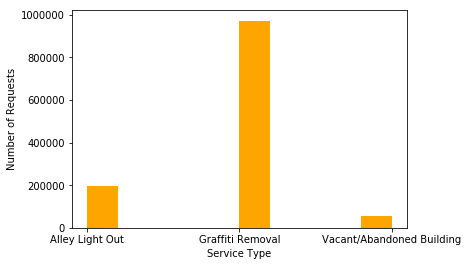

In [9]:
def visualize_top_level():
    plt.xlabel('Service Type')
    plt.ylabel('Number of Requests')
    plt.hist(clean_311['type_of_service_request'], color = 'orange')
    plt.show()

visualize_top_level()

### Number of Service Requests Throughout Year

There appears to be a higher number of requests submitted in December and January than any other month.

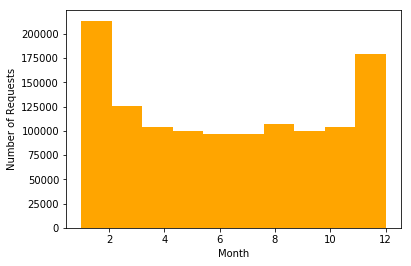

In [10]:
plt.xlabel('Month')
plt.ylabel('Number of Requests')
plt.hist(clean_311['month'], color = 'orange')
plt.show()

### Number Service Requests Year Over Year

The number of service requests year over year appears to have been declining slightly since 2013, after a large drop-off in 2011. Note that this is the year Rahm Emanuel became Mayor of Chicago.

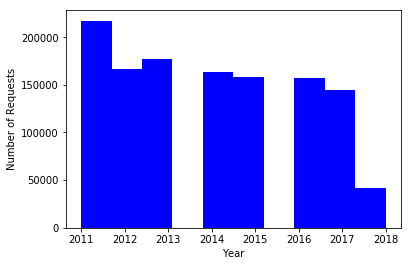

In [11]:
plt.xlabel('Year')
plt.ylabel('Number of Requests')
plt.hist(clean_311['year'], color = 'blue')
plt.show()

### Response Time to Service Requests

There is significantly more variation in response time for alley light out service requests than in graffiti removal requests, and average request resolution time is over 10 times longer for this type of request. 

Note that the city does not share completion dates for abandoned building requests, which could potentially be due to a variety of factors including but certainly not limited to exorbitantly long response times the city is not comfortable sharing, or simply the limited capacity of the city's data team.

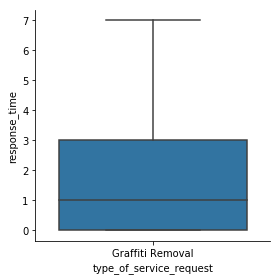

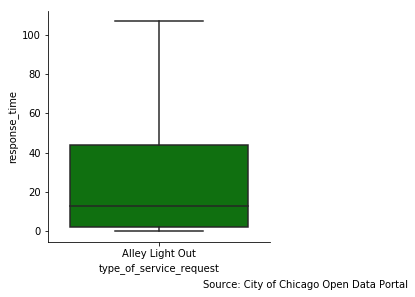

In [12]:
sns.factorplot(data=clean_311[clean_311['type_of_service_request'] == 'Graffiti Removal'], x='type_of_service_request', y='response_time', kind='box',showfliers=False)
sns.factorplot(data=clean_311[clean_311['type_of_service_request'] == 'Alley Light Out'], x='type_of_service_request', y='response_time', kind='box', color = 'green', showfliers=False)
plt.annotate('Source: City of Chicago Open Data Portal', xy=(0.7,-0.2), xycoords="axes fraction")
plt.tight_layout()

plt.show()

### Requests by Geography

In [13]:
def compile_geo_df(df):
    geo_ready = df[df['latitude'] != '']
    geo_grouping = geo_ready[['latitude', 'longitude', 'type_of_service_request', 'service_request_number']].groupby(['latitude', 'longitude', 'type_of_service_request']).count().unstack('type_of_service_request')
    geo_grouping = geo_grouping.fillna('0')
    geo_grouping_plot_ready = geo_grouping.reset_index()
    geo_grouping_plot_ready.columns = geo_grouping_plot_ready.columns.droplevel(0)
    geo_grouping_plot_ready = geo_grouping_plot_ready.reset_index().rename_axis(None, axis=1)
    geo_grouping_plot_ready.drop(['index'], axis = 1)
    geo_grouping_plot_ready.columns = ['index', 'latitude', 'longitude', 'Alley Light Out', 'Graffiti Removal','Vacant/Abandoned Building']
    
    return geo_grouping_plot_ready
    


In [125]:
plot_lat_lon = compile_geo_df(clean_311)

In [126]:
plot_lat_lon.head()

,index,latitude,longitude,Alley Light Out,Graffiti Removal,Vacant/Abandoned Building
0,0,41.64469535649149,-87.53980386178681,0,1,0
1,1,41.6447117352697,-87.5408663803913,0,1,0
2,2,41.64471259298648,-87.61146904483418,0,1,0
3,3,41.64473930758664,-87.5409026350459,0,1,0
4,4,41.64536949643727,-87.61722129247524,0,0,1


In [ ]:
fig, axes = plt.subplots(figsize=[16, 10], nrows= 3, ncols = 1, sharex='row', sharey='row', squeeze = True)

ax1, ax2, ax3 = axes

graffiti_scatter = ax1.scatter(plot_lat_lon['longitude'], plot_lat_lon['latitude'], c=plot_lat_lon['Graffiti Removal'], edgecolor='None', alpha=0.7, cmap=plt.get_cmap('icefire'))
#ax1.set_xlim( [37,45])
#ax1.set_ylim( [-90,-84])
ax1.set_title('Graffiti Requests')
ax1.set_ylabel('Latitude')

building_scatter = ax2.scatter(plot_lat_lon['longitude'], plot_lat_lon['latitude'], c=plot_lat_lon['Vacant/Abandoned Building'], edgecolor='None', alpha=0.7, cmap=plt.get_cmap('icefire'))
#ax1.set_xlim( [37,45])
#ax1.set_ylim( [-90,-84])
ax2.set_ylabel('Latitude')
ax2.set_title('Abandoned Building Requests')

cholesterol_scatter = ax3.scatter(plot_lat_lon['longitude'], plot_lat_lon['latitude'],  c=plot_lat_lon['Alley Light Out'], edgecolor='None', alpha=0.7, cmap=plt.get_cmap('icefire'))
#ax1.set_xlim( [37,45])
#ax1.set_ylim( [-90,-84])
ax3.set_title('Alley Light Out Requests')
ax3.set_xlabel('Longitude')
ax3.set_ylabel('Latitude')
plt.annotate('Source: Source: City of Chicago Open Data Portal', xy=(0.2,-0.3), xycoords="axes fraction")


### Top 10 Zipcodes for Graffiti Requests

In [16]:
def requests_by_geo(df, geo):
    clean_geo_311 = df[(df[geo] != 0) & (df[geo] != '') & (df[geo] != '0')]
    geo_requests = clean_geo_311.groupby(['zip','type_of_service_request'])['service_request_number'].count().unstack('type_of_service_request')
    geo_requests['% of Total Alley Light Out'] = (geo_requests['Alley Light Out'] / geo_requests['Alley Light Out'].sum() * 100)
    geo_requests['% of Graffiti Requests'] = (geo_requests['Graffiti Removal'] / geo_requests['Graffiti Removal'].sum() * 100)
    geo_requests['% of Vacant/Abandoned Building'] = (geo_requests['Vacant/Abandoned Building'] / geo_requests['Vacant/Abandoned Building'].sum() * 100)
    geo_requests = geo_requests.drop(['Alley Light Out', 'Graffiti Removal', 'Vacant/Abandoned Building'], axis = 1)
    geo_requests.fillna(value = 0, inplace = True)
    return geo_requests

geo_req_data = requests_by_geo(clean_311, 'zip')

In [17]:
graffiti_zips = geo_req_data.sort_values(by = ['% of Graffiti Requests', '% of Vacant/Abandoned Building', '% of Total Alley Light Out'], ascending = False)[:10]
graffiti_zips

type_of_service_request,% of Total Alley Light Out,% of Graffiti Requests,% of Vacant/Abandoned Building
zip,,,
60632,3.615774,10.948052,1.917495
60608,2.303798,8.668387,1.512953
60647,2.405964,7.947025,1.380524
60618,2.814123,7.374896,1.126551
60623,2.885437,5.853850,3.974675
60629,6.194207,5.604271,3.466730
60609,2.517234,4.672747,5.137508
60639,2.747867,4.445604,1.545606
60622,1.540586,4.332393,0.669400


### Top 10 Zipcodes for Vacant Building Requests

In [18]:
vacant_bldg_zips = geo_req_data.sort_values(by = ['% of Vacant/Abandoned Building', '% of Total Alley Light Out', '% of Graffiti Requests'], ascending = False)[:10]
vacant_bldg_zips

type_of_service_request,% of Total Alley Light Out,% of Graffiti Requests,% of Vacant/Abandoned Building
zip,,,
60636,2.186964,0.396034,10.184312
60628,5.809313,0.320182,9.899499
60621,1.311470,0.199664,7.011465
60617,6.045509,2.162028,6.875408
60619,4.568651,0.164156,6.106233
60620,4.718360,0.257607,6.079022
60624,1.633142,0.336855,5.193745
60609,2.517234,4.672747,5.137508
60651,3.528275,0.930391,4.027284


### Top 10 Zipcodes for Alley Light Out Requests

In [19]:
alley_zips = geo_req_data.sort_values(by = ['% of Total Alley Light Out','% of Graffiti Requests', '% of Vacant/Abandoned Building'], ascending = False)[:10]
alley_zips

type_of_service_request,% of Total Alley Light Out,% of Graffiti Requests,% of Vacant/Abandoned Building
zip,,,
60629,6.194207,5.604271,3.466730
60617,6.045509,2.162028,6.875408
60628,5.809313,0.320182,9.899499
60638,4.881219,1.080448,0.576881
60620,4.718360,0.257607,6.079022
60619,4.568651,0.164156,6.106233
60632,3.615774,10.948052,1.917495
60634,3.560645,1.823938,0.841739
60651,3.528275,0.930391,4.027284


### Double-Whammy Zipcodes
#### Zipcodes in top 10 for multiple service request types

* Zipcodes near Midway airport (60632, 60629) have a higher percentage of both vacant/ abandonded building service requests. 
* Austin/ Humbolt Park border (60651), Calumet Heights/ South Derring/ East Side (60617), Auburn Gresham/ Chathm border (60620, 60619), and the Pullman/ Roseland area (60628) have had higher percentages of graffiti and alley light our service requests since 2011. 
* North and South Lawndale/ Little Village (60623), and Back of the Yards/ Fuller Park (60609) have both higher rates of vacant building requests and higher rates of graffiti requests.

In [20]:
alley_set = set(alley_zips.index)
bldg_set = set(graffiti_zips.index)
graffiti_set = set(vacant_bldg_zips.index)

print("""Zip codes high in both vacant building and alley light out requests: 
{}""".format(alley_set.intersection(bldg_set)))
print()
print("""Zip codes high in both graffiti and alley light out requests: 
{}""".format(alley_set.intersection(graffiti_set)))
print()
print("""Zip codes high in both vacant building and graffiti out requests: 
{}""".format(bldg_set.intersection(graffiti_set)))

Zip codes high in both vacant building and alley light out requests: 
{'60629', '60632'}

Zip codes high in both graffiti and alley light out requests: 
{'60619', '60628', '60617', '60651', '60620'}

Zip codes high in both vacant building and graffiti out requests: 
{'60609', '60623'}


### Service Request Subtype Breakdown

For abandoned buildings, 85% of reported buildings were open and vulnerable to squatters. 46% of  abandoned buildings were reported in-use by people experiencing homelessness, gangs, or children.

Just under 60% of 971,794 graffiti removal requests were for graffiti on brick or painted metal. Less than one percent of graffiti requests were for graffiti removal from limestone, marble/ granite, asphalt, stuccko, and trees. This begs the question of whether Chicagoans refrained from tagging these harder-to-clean surfaces, or if those who noticed intances of graffiti on these materials were just too skeptical of the city's abiilty to remove it to report them.  

### Total Number of Requests by Service Type

In [38]:
#topline_totals = clean_311[['type_of_service_request', 'service_request_number']].groupby('type_of_service_request').count()


def eval_request_ratios(df):
    request_probs = df[['type_of_service_request', 'service_request_number']].groupby(['type_of_service_request']).count() 
    request_probs['percentage_of_requests'] = ((df[['type_of_service_request', 'service_request_number']].groupby(['type_of_service_request']).count() / df[['type_of_service_request', 'service_request_number']].groupby('type_of_service_request').count().sum()) * 100)['service_request_number']
    request_probs.rename(columns = {'type_of_service_request': 'type_of_service_request', 'service_request_number': 'number_of_requests', 'percentage_of_requests': 'percentage_of_requests'}, inplace=True)
    request_probs = request_probs.sort_values(by = ['percentage_of_requests', 'number_of_requests'], ascending = False)[:10]
    return request_probs
    

In [40]:
topline_totals = eval_request_ratios(clean_311)
topline_totals

,number_of_requests,percentage_of_requests
type_of_service_request,,
Graffiti Removal,972433,79.314561
Alley Light Out,198148,16.161547
Vacant/Abandoned Building,55465,4.523892


### Number of Requests by Subtype

In [41]:
def view_subtypes(df):
    subtypes = {'Graffiti Removal': ['surface_type'], 'Alley Light Out': [], 'Vacant/Abandoned Building': ['boarded_indicator', 'fire_indicator', 'hazardous_indicator',
                'in_use', 'vacant_indicator']}

    
    service_types = df['type_of_service_request'].unique()
   
    top_level_counts = df['type_of_service_request'].value_counts()

    count_dict = {}
    frame_list = []
    for service_type, count in top_level_counts.items(): 
        count_dict[service_type] = count
    
    for service in service_types:
        service_reqs = df[saved_311['type_of_service_request'] == service]
        service_subs = subtypes[service]
        if len(service_subs) > 0:
            stats = pd.DataFrame()
            cols = [stats]
        else:
            cols = None
        for subtype in service_subs:
            sub_counts = service_reqs[subtype].value_counts() 
            cols.append(sub_counts)
        if cols:
            stats_frame = pd.concat(cols, axis = 1)
            stats_frame.fillna(value = 0, inplace = True)
            frame_list.append(stats_frame)
        
    return frame_list

In [45]:
bldgs_subs, graffiti_subs  = view_subtypes(saved_311) 
bldgs_subs.sort_values(by = ['boarded_indicator', 'fire_indicator', 'hazardous_indicator', 'in_use', 'vacant_indicator'], ascending = False)

,boarded_indicator,fire_indicator,hazardous_indicator,in_use,vacant_indicator
Open,47086.0,0.0,0.0,0.0,0.0
,7878.0,8730.0,62133.0,8167.0,7870.0
Boarded,6878.0,0.0,0.0,0.0,0.0
Building is Open / Unsecure,258.0,0.0,0.0,0.0,0.0
Building is Boarded Up,33.0,0.0,0.0,0.0,0.0
false,0.0,49119.0,0.0,28429.0,0.0
true,0.0,4284.0,0.0,25537.0,0.0
Vacant,0.0,0.0,0.0,0.0,53494.0
Occupied,0.0,0.0,0.0,0.0,761.0
Unknown,0.0,0.0,0.0,0.0,8.0


In [46]:
graffiti_subs.sort_values(by = 'surface_type', ascending = False)

,surface_type
Brick - Unpainted,217945
Metal - Painted,189260
Brick - Painted,179855
Other / Unknown Surface,88889
"Cement (Sidewalk, Alley, Wall, Curb)",61079
Wood - Painted,52189
Metal,47903
Aluminum Siding,45224
Metal - Unpainted,26286
Vinyl Siding,15619


## Data Augmentation and APIs

Based on this augmented data, provide some descriptive statistics to describe:

1. What types of blocks get “Vacant and Abandoned Buildings Reported”?
2. What types of blocks get “Alley Lights Out”?
3. Does that change over time in the data you collected?

4. What is the difference in blocks that get “Vacant and Abandoned Buildings Reported” vs “Alley Lights Out”?

In [127]:
def remove_blanks(df):
    altered_df = df[(df['latitude'] != '') & (df['longitude'] != '')]
    return altered_df

In [128]:
loc_ready_311 = remove_blanks(clean_311) 

In [131]:
# double-check for missing lat/ lon values
loc_ready_311[(loc_ready_311.latitude.isin(['', None])) | (loc_ready_311.longitude.isin(['', None]))]

,boarded_indicator,community_area,completion_date,creation_date,entry_point,fire_indicator,hazardous_indicator,in_use,latitude,location,...,street_suff,surface_type,type_of_service_request,vacant_indicator,ward,x_coordinate,y_coordinate,zip,month,year


In [133]:
# check for non-standard latitude formats
loc_ready_311[loc_ready_311[['latitude', 'longitude']].applymap(lambda x: isinstance(x, (int)))['latitude']]

,boarded_indicator,community_area,completion_date,creation_date,entry_point,fire_indicator,hazardous_indicator,in_use,latitude,location,...,street_suff,surface_type,type_of_service_request,vacant_indicator,ward,x_coordinate,y_coordinate,zip,month,year


In [134]:
# check for non-standard longitude formats
loc_ready_311[loc_ready_311[['latitude', 'longitude']].applymap(lambda x: isinstance(x, (int)))['longitude']]

,boarded_indicator,community_area,completion_date,creation_date,entry_point,fire_indicator,hazardous_indicator,in_use,latitude,location,...,street_suff,surface_type,type_of_service_request,vacant_indicator,ward,x_coordinate,y_coordinate,zip,month,year


In [135]:
small = loc_ready_311.sample(n=311)

In [136]:
acs_variables = {
    "B01003_001E": "block_population",
    "B15003_022E": "bachelors_degree",
    "B03001_003E": "hispan_pop",
    "B02001_002E": "white_pop",
    "B17001_002E": "under_poverty_line",
    "B02001_003E": "black_pop",
    "C24010_059E": "female_law_enforcement",
    "C24010_023E": "male_law_enforcement",
    "B08136_011E": "walk_commute_minutes",
    "B19013_001E": "median_income",
    "tract": "census_tract",
    "block group": "block_group"
}

In [137]:
small.head()

,boarded_indicator,community_area,completion_date,creation_date,entry_point,fire_indicator,hazardous_indicator,in_use,latitude,location,...,street_suff,surface_type,type_of_service_request,vacant_indicator,ward,x_coordinate,y_coordinate,zip,month,year
417293,NaN,31,2013-10-28,2013-10-25,NaN,NaN,NaN,NaN,41.85816228449166,"(41.85816228449166, -87.64942509932504)",...,NaN,Metal - Painted,Graffiti Removal,NaN,25,NaN,1891606.06359751,60608,10,2013
895329,NaN,65,2017-08-23,2017-08-23,NaN,NaN,NaN,NaN,41.78098288059131,"(41.78098288059131, -87.72297299028439)",...,NaN,Brick - Unpainted,Graffiti Removal,NaN,23,NaN,1863459.32988053,60629,8,2017
9002,Open,71,NaT,2011-03-16,FRONT AND BACK DOOR,false,,true,41.74834503062724,"(41.74834503062724, -87.65246947974288)",...,ST,NaN,Vacant/Abandoned Building,Vacant,21,1170045.36411898,1851623.04419844,60620,3,2011
946246,NaN,15,2018-01-16,2018-01-16,NaN,NaN,NaN,NaN,41.96055888253856,"(41.96055888253856, -87.74737200961452)",...,NaN,Brick - Unpainted,Graffiti Removal,NaN,45,NaN,1928603.52122684,60641,1,2018
36503,NaN,10,2011-08-02,2011-06-27,NaN,NaN,NaN,NaN,41.99509659947298,"(41.99509659947298, -87.81705797004554)",...,NaN,NaN,Alley Light Out,NaN,41,1124591.19910696,1941226.20800492,60631,6,2011


In [138]:
def add_acs_variables(df):
    for var, col in acs_variables.items():
        df[col] = None

In [139]:
add_acs_variables(small)
small.head()

,boarded_indicator,community_area,completion_date,creation_date,entry_point,fire_indicator,hazardous_indicator,in_use,latitude,location,...,hispan_pop,white_pop,under_poverty_line,black_pop,female_law_enforcement,male_law_enforcement,walk_commute_minutes,median_income,census_tract,block_group
417293,NaN,31,2013-10-28,2013-10-25,NaN,NaN,NaN,NaN,41.85816228449166,"(41.85816228449166, -87.64942509932504)",...,None,None,None,None,None,None,None,None,None,None
895329,NaN,65,2017-08-23,2017-08-23,NaN,NaN,NaN,NaN,41.78098288059131,"(41.78098288059131, -87.72297299028439)",...,None,None,None,None,None,None,None,None,None,None
9002,Open,71,NaT,2011-03-16,FRONT AND BACK DOOR,false,,true,41.74834503062724,"(41.74834503062724, -87.65246947974288)",...,None,None,None,None,None,None,None,None,None,None
946246,NaN,15,2018-01-16,2018-01-16,NaN,NaN,NaN,NaN,41.96055888253856,"(41.96055888253856, -87.74737200961452)",...,None,None,None,None,None,None,None,None,None,None
36503,NaN,10,2011-08-02,2011-06-27,NaN,NaN,NaN,NaN,41.99509659947298,"(41.99509659947298, -87.81705797004554)",...,None,None,None,None,None,None,None,None,None,None


In [162]:
def get_fips(lat, lon):
    try:
        response = requests.get("https://geo.fcc.gov/api/census/block/find?latitude={}&longitude={}&showall=false&format=json".format(lat, lon))
        result = response.json()
        block_group = result['Block']['FIPS'][11]
        tract = result['Block']['FIPS'][5:11]
        return (block_group, tract)
    except:
        print(lat, lon)

def get_acs_data(lat, lon):
    group, tract = get_fips(lat, lon)
    response = requests.get("https://api.census.gov/data/2015/acs5?get=NAME,B01003_001E,B15003_022E,B03001_003E,B02001_002E,B17001_002E,B02001_003E,C24010_059E,C24010_023E,B08136_011E,B19013_001E&for=block%20group:{}&in=state:17%20county:031%20tract:{}&key={}".format(group, tract, CENSUS_KEY))
    return response.json()

In [141]:
def retrive_responses(lat, lon, vars_mapping):
    acs_response = get_acs_data(lat, lon)
    vars_req = acs_response[0]
    
    # make sure None values are included
    vars_response = [var if var is not None else 0 for var in acs_response[1]]
    assert len(vars_req) == len(vars_response)
    
    #vars_dict = {'latitude': float(lat), 'longitude': float(lon)}
    vars_dict = {}
    
    for ind, req in enumerate(vars_req):
        # skip variables with redundant information
        if req in ('NAME', 'county', 'state'):
            continue
        
        focus_var = vars_mapping[req] 
        
        if focus_var == 'census_tract':
            vars_dict[focus_var] = vars_response[ind]
        else:
            vars_dict[focus_var] = int(vars_response[ind]) 
            
    return vars_dict

In [142]:
def populate_acs_data(df):
    for row in df.itertuples():
        acs_dict = retrive_responses(row.latitude, row.longitude, acs_variables)
    
        for var, val in acs_dict.items():
            df.loc[row.Index, var] = val

In [143]:
populate_acs_data(small)
small.tail()

,boarded_indicator,community_area,completion_date,creation_date,entry_point,fire_indicator,hazardous_indicator,in_use,latitude,location,...,hispan_pop,white_pop,under_poverty_line,black_pop,female_law_enforcement,male_law_enforcement,walk_commute_minutes,median_income,census_tract,block_group
363616,NaN,22,2013-06-21,2013-06-19,NaN,NaN,NaN,NaN,41.917965225618026,"(41.917965225618026, -87.71011718901282)",...,0,1150,0,51,0,0,0,30781,221100,2
850006,NaN,6,2017-03-13,2017-03-09,NaN,NaN,NaN,NaN,41.9395134055597,"(41.9395134055597, -87.63710726441985)",...,0,1333,0,74,0,0,0,117929,063200,4
953370,NaN,59,2018-02-05,2018-02-05,NaN,NaN,NaN,NaN,41.828474896477175,"(41.828474896477175, -87.6753811584619)",...,0,679,0,0,23,0,0,38924,590600,1
344367,NaN,22,2013-05-07,2013-04-26,NaN,NaN,NaN,NaN,41.91742276227435,"(41.91742276227435, -87.69221180721557)",...,0,1065,0,18,0,0,0,86776,832400,2
504409,NaN,5,2014-05-28,2014-05-21,NaN,NaN,NaN,NaN,41.95568887002181,"(41.95568887002181, -87.68351215576395)",...,0,1716,0,43,0,0,0,60614,050200,3


In [146]:
test_sample = small.sample(n=1)
test_ind = test_sample.index.values[0]
test_ind

146188

In [147]:
# run test case to evaluate whether results are mapped correctly
acs_response_dict = retrive_responses(small.loc[test_ind, 'latitude'], small.loc[test_ind, 'longitude'], acs_variables)

acs_response_dict

{'bachelors_degree': 311,
 'black_pop': 209,
 'block_group': 1,
 'block_population': 1246,
 'census_tract': '838200',
 'female_law_enforcement': 0,
 'hispan_pop': 0,
 'male_law_enforcement': 0,
 'median_income': 48478,
 'under_poverty_line': 0,
 'walk_commute_minutes': 0,
 'white_pop': 746}

In [150]:
# isolate columns with relevant/ newly populated data for comparison with test case
test_cols_list = ['latitude', 'longitude', 'zip', 'type_of_service_request', 'block_population', 'bachelors_degree','hispan_pop', 'white_pop', 'under_poverty_line', 'black_pop', 'female_law_enforcement', 'male_law_enforcement', 'walk_commute_minutes', 'median_income', 'census_tract', 'block_group'] 
test_df = small[test_cols_list]

# compare to row at selected index
# test_df.
test_df.loc[test_ind]

latitude                   41.873881137971864
longitude                  -87.67977883451826
zip                                     60612
type_of_service_request      Graffiti Removal
block_population                         1246
bachelors_degree                          311
hispan_pop                                  0
white_pop                                 746
under_poverty_line                          0
black_pop                                 209
female_law_enforcement                      0
male_law_enforcement                        0
walk_commute_minutes                        0
median_income                           48478
census_tract                           838200
block_group                                 1
Name: 146188, dtype: object

### Characteristics of Blocks Reporting Vacant/Abandoned Buildings and Alley Lights Out

**Due to API call limits and timing, evaluation was run on a sample of 311 records**

As might be expected, block groups with abandoned building complaints appear to have lower populations on average (65% and 79% of blocks reporting graffiti and alley light out requests, respectively. Blocks reporting abandoned buildings also have significantly lower average rates of post-secondary education, and a much higher proportion of Black residents (over 5 times that of block groups reporting graffiti and 1.5 times those reporting alley lights out. Average median income in these block groups is 60-64% of median in areas reporting graffiti or alley lights out. 

Areas reporting alley lights out have a significantly higher proportion of male residents working in law enforcement (nearly double blocks reporting graffiti and over four times blocks reporting abandoned buildings), with average block group population almost exactly between graffiti and abandoned buildings. The white population in these blocks is about 3.5 times the white population in blocks reporting abondoned buildings. Average walking commute time in these blocks is nearly sixty minutes, so it is possible these residents see more alley lights out than counterparts in other blocks, or feel more strongly about having lighted paths when walking after dark.  

In [151]:
# identify columns containing data for analysis with census data
eval_cols_list = ['latitude', 'longitude', 'creation_date', 'month', 'year', 'street_address', 'zip', 'ward', 'community_area', 'type_of_service_request', 'service_request_number','response_time']
acs_cols_list = ['block_population', 'bachelors_degree','hispan_pop', 'white_pop', 'under_poverty_line', 'black_pop', 'female_law_enforcement', 'male_law_enforcement', 'walk_commute_minutes', 'median_income', 'census_tract', 'block_group']
full_eval_list = eval_cols_list +  acs_cols_list          

In [152]:
def eval_service_type_bldg(df, type_only = False):
    bldg_test = acs_cols_list + ['type_of_service_request']

    for var in acs_cols_list:
        if var != 'census_tract':
            df[var]= df[var].astype(int)

    if type_only:
        counts = df[bldg_test].groupby(['type_of_service_request']).mean()
        return counts
    else:
        counts = df[bldg_test].groupby(['type_of_service_request', 'block_group']).mean()
        return counts

In [153]:
eval_service_type_bldg(small, type_only = True)

,block_population,bachelors_degree,hispan_pop,white_pop,under_poverty_line,black_pop,female_law_enforcement,male_law_enforcement,walk_commute_minutes,median_income,block_group
type_of_service_request,,,,,,,,,,,
Alley Light Out,1238.317073,143.707317,0.0,488.170732,0.0,527.219512,2.878049,8.097561,57.560976,49842.341463,2.317073
Graffiti Removal,1521.773077,211.373077,0.0,938.503846,0.0,152.442308,1.400000,3.680769,114.000000,51869.707692,2.019231
Vacant/Abandoned Building,989.100000,71.700000,0.0,140.100000,0.0,779.800000,0.000000,1.300000,0.000000,31625.100000,2.700000


## Extrapolation

**Assume you are running the 311 call center for Chicago. You get a call from 3600 W Roosevelt Rd.**

1. **Of the three types of requests you have data for, which request type is the most likely given the call came from 3600 W Roosevelt Ave? What are the probabilities for each type of request?**

In [154]:
focus = clean_311[clean_311['street_address'] == '3600 W ROOSEVELT RD']
focus

,boarded_indicator,community_area,completion_date,creation_date,entry_point,fire_indicator,hazardous_indicator,in_use,latitude,location,...,street_suff,surface_type,type_of_service_request,vacant_indicator,ward,x_coordinate,y_coordinate,zip,month,year
567191,NaN,29,2014-11-19,2014-11-19,NaN,NaN,NaN,NaN,41.86639889180933,"(41.86639889180933, -87.71548367828538)",...,NaN,Metal - Painted,Graffiti Removal,NaN,24,NaN,1894471.7604274,60624,11,2014
675421,NaN,29,2015-09-23,2015-09-23,NaN,NaN,NaN,NaN,41.86639889180933,"(41.86639889180933, -87.71548367828538)",...,NaN,Metal - Painted,Graffiti Removal,NaN,24,NaN,1894471.7604274,60624,9,2015
814725,NaN,29,2016-11-11,2016-11-11,NaN,NaN,NaN,NaN,41.86639889180933,"(41.86639889180933, -87.71548367828538)",...,NaN,Metal - Painted,Graffiti Removal,NaN,24,NaN,1894471.7604274,60624,11,2016
918132,NaN,29,2017-10-23,2017-10-23,NaN,NaN,NaN,NaN,41.86639889180933,"(41.86639889180933, -87.71548367828538)",...,NaN,Metal - Unpainted,Graffiti Removal,NaN,24,NaN,1894471.7604274,60624,10,2017


In [155]:
add_acs_variables(focus)
populate_acs_data(focus)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [156]:
focus = focus[full_eval_list]
focus

,latitude,longitude,creation_date,month,year,street_address,zip,ward,community_area,type_of_service_request,...,hispan_pop,white_pop,under_poverty_line,black_pop,female_law_enforcement,male_law_enforcement,walk_commute_minutes,median_income,census_tract,block_group
567191,41.86639889180933,-87.71548367828538,2014-11-19,11,2014,3600 W ROOSEVELT RD,60624,24,29,Graffiti Removal,...,0,0,0,1273,0,0,0,15756,843000,1
675421,41.86639889180933,-87.71548367828538,2015-09-23,9,2015,3600 W ROOSEVELT RD,60624,24,29,Graffiti Removal,...,0,0,0,1273,0,0,0,15756,843000,1
814725,41.86639889180933,-87.71548367828538,2016-11-11,11,2016,3600 W ROOSEVELT RD,60624,24,29,Graffiti Removal,...,0,0,0,1273,0,0,0,15756,843000,1
918132,41.86639889180933,-87.71548367828538,2017-10-23,10,2017,3600 W ROOSEVELT RD,60624,24,29,Graffiti Removal,...,0,0,0,1273,0,0,0,15756,843000,1


In [157]:
focus_grouped = ((focus[['type_of_service_request', 'service_request_number']].groupby('type_of_service_request').count() / focus[['type_of_service_request', 'service_request_number']].groupby('type_of_service_request').count().sum()) * 100)
focus_grouped.rename(columns = {'type_of_service_request': 'type_of_service_request', 'service_request_number': 'percentage_of_requests'}, inplace=True)
focus_grouped

,percentage_of_requests
type_of_service_request,
Graffiti Removal,100.0


The probability that the call is requesting graffiti removal is 100%, the probability that the call is reporting alley lights out or an abandoned building is 0%. 

**Let’s now assume that a call comes in about Graffiti Removal.**

Which is more likely – that the call came from Garfield Park or Uptown? How much more or less likely is it to be from Garfield Park vs Uptown?

In [158]:
# Garfield Park zip code: 60612
# Uptown zip code: 60640
zip_df = clean_311[(clean_311['zip'] == '60612') | (clean_311['zip'] == '60640')]
zip_df = zip_df[zip_df['creation_date'].dt.year > 2017]
zip_df.head()

,boarded_indicator,community_area,completion_date,creation_date,entry_point,fire_indicator,hazardous_indicator,in_use,latitude,location,...,street_suff,surface_type,type_of_service_request,vacant_indicator,ward,x_coordinate,y_coordinate,zip,month,year
61071,Open,23,NaT,2018-01-12,FRONT AND REAR,false,,false,41.89096524336207,"(41.89096524336207, -87.70641767118971)",...,AVE,NaN,Vacant/Abandoned Building,Vacant,27,1154944.63347562,1903481.2316104,60612,1,2018
61095,,27,NaT,2018-01-12,,,,,41.88281335223568,"(41.88281335223568, -87.70438295435892)",...,BLVD,NaN,Vacant/Abandoned Building,,27,1155520.4145244,1900514.74458981,60612,1,2018
61282,Open,27,NaT,2018-01-11,NOT BOARDED UP,false,,true,41.88201602337492,"(41.88201602337492, -87.69393981101048)",...,BLVD,NaN,Vacant/Abandoned Building,Vacant,27,1158366.38009569,1900245.21360414,60612,1,2018
61322,Open,29,NaT,2018-01-11,,false,,true,41.86801119657415,"(41.86801119657415, -87.69838724534392)",...,AVE,NaN,Vacant/Abandoned Building,Vacant,28,1157193.02420904,1895132.88608422,60612,1,2018
61531,Boarded,24,NaT,2018-02-13,,false,,true,41.89076887231502,"(41.89076887231502, -87.68024347454892)",...,AVE,NaN,Vacant/Abandoned Building,Vacant,26,1162071.83980258,1903462.8304082,60612,2,2018


In [160]:
zip_df_clean = remove_blanks(zip_df)
zip_df_blanks = zip_df_clean[(zip_df_clean['latitude'] == '') | (zip_df_clean['longitude'] == '')]
zip_df_blanks

,boarded_indicator,community_area,completion_date,creation_date,entry_point,fire_indicator,hazardous_indicator,in_use,latitude,location,...,street_suff,surface_type,type_of_service_request,vacant_indicator,ward,x_coordinate,y_coordinate,zip,month,year


In [163]:
add_acs_variables(zip_df_clean)
populate_acs_data(zip_df_clean)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [164]:
zip_df_clean = zip_df_clean[full_eval_list]
zip_df_clean.head()

,latitude,longitude,creation_date,month,year,street_address,zip,ward,community_area,type_of_service_request,...,hispan_pop,white_pop,under_poverty_line,black_pop,female_law_enforcement,male_law_enforcement,walk_commute_minutes,median_income,census_tract,block_group
61071,41.89096524336207,-87.70641767118971,2018-01-12,1,2018,541 N KEDZIE AVE,60612,27,23,Vacant/Abandoned Building,...,0,25,0,783,0,0,0,20500,836700,1
61095,41.88281335223568,-87.70438295435892,2018-01-12,1,2018,3127 W WASHINGTON BLVD,60612,27,27,Vacant/Abandoned Building,...,0,0,0,544,0,18,0,22885,837100,1
61282,41.88201602337492,-87.69393981101048,2018-01-11,1,2018,2750 W WARREN BLVD,60612,27,27,Vacant/Abandoned Building,...,0,46,0,881,0,0,0,29107,837400,1
61322,41.86801119657415,-87.69838724534392,2018-01-11,1,2018,1116 S FRANCISCO AVE,60612,28,29,Vacant/Abandoned Building,...,0,42,0,663,0,0,0,8478,838600,2
61531,41.89076887231502,-87.68024347454892,2018-02-13,2,2018,2136 W GRAND AVE,60612,26,24,Vacant/Abandoned Building,...,0,1219,0,0,0,0,0,66964,243000,2


In [165]:
request_probs = eval_request_ratios(zip_df_clean)
request_probs

,number_of_requests,percentage_of_requests
type_of_service_request,,
Graffiti Removal,1384,86.662492
Alley Light Out,198,12.398247
Vacant/Abandoned Building,15,0.939261


In [166]:
neighborhood_probs = zip_df_clean[['zip', 'service_request_number']].groupby(['zip']).count() 
neighborhood_probs['percentage_of_requests'] = ((zip_df_clean[['zip', 'service_request_number']].groupby(['zip']).count() / zip_df_clean[['zip', 'service_request_number']].groupby('zip').count().sum()) * 100)['service_request_number']
neighborhood_probs.rename(columns = {'zip': 'zip', 'service_request_number': 'number_of_requests', 'percentage_of_requests': 'percentage_of_requests'}, inplace=True)
neighborhood_probs

,number_of_requests,percentage_of_requests
zip,,
60612,714,44.708829
60640,883,55.291171


In [167]:
zip_request_probs = zip_df_clean[['type_of_service_request', 'zip', 'service_request_number']].groupby(['type_of_service_request', 'zip']).count() 
zip_request_probs['percentage_of_requests'] = ((zip_df_clean[['type_of_service_request', 'zip', 'service_request_number']].groupby(['type_of_service_request', 'zip']).count() / zip_df_clean[['type_of_service_request', 'zip', 'service_request_number']].groupby('type_of_service_request').count()) * 100)['service_request_number']
zip_request_probs.rename(columns = {'type_of_service_request': 'type_of_service_request', 'service_request_number': 'number_of_requests', 'percentage_of_requests': 'percentage_of_requests'}, inplace=True)

zip_request_probs

number_of_requests  percentage_of_requests
type_of_service_request   zip                                              
Alley Light Out           60612                 132               66.666667
                          60640                  66               33.333333
Graffiti Removal          60612                 569               41.112717
                          60640                 815               58.887283
Vacant/Abandoned Building 60612                  13               86.666667
                          60640                   2               13.333333

In [168]:
# conditional probability: P(A | B) = P(A and B)/ P(B)
def conditional_probability(prob_a, prob_b):
    joint_prob = prob_a * prob_b
    return joint_prob/ prob_b

In [169]:
probs_graffiti = request_probs.loc['Graffiti Removal', 'number_of_requests'] / (request_probs.number_of_requests.sum())

probs_uptown = neighborhood_probs.loc['60640', 'number_of_requests'] / (neighborhood_probs.number_of_requests.sum())

probs_garfield = neighborhood_probs.loc['60612', 'number_of_requests'] / (neighborhood_probs.number_of_requests.sum())

In [170]:
prob_garfield_call = conditional_probability(probs_garfield, probs_graffiti)
prob_uptown_call = conditional_probability(probs_uptown, probs_graffiti)

In [171]:
likelihood_diff = prob_garfield_call - prob_uptown_call
likelihood_diff_pct = likelihood_diff * 100
likelihood_diff_pct

-10.582341891045715

It is more likely that the call came from Uptown. 

Based on the last three months (Jan - March 2018), during which just under 60% of graffiti removal requests from the two neighborhoods came from Uptown, a call for graffiti removal is about 11% more likely to come from Uptown than from Garfield Park.

**Now assume that you don’t have access to all the raw data and you know the following things:**
    
   * There are a total of 1000 calls, 600 from Garfield Park and 400 from Uptown.
   * Of the 600 calls from Garfield Park, 100 of them are about Graffiti Removal.
   * Of the 400 calls from Uptown, 160 are about Graffiti Removal. 

    If a call comes about Graffiti Removal, how much more/less likely is it that the call came from Garfield Park versus Uptown?

In [173]:
garfield_probs = 600/ 1000
uptown_probs = 400/ 1000
garfield_graffiti = 100/ 600
uptown_graffiti = 160/ 400
prob_graffiti = (100 + 160)/ 1000

In [174]:
prob_garfield_given_graffiti = conditional_probability(garfield_probs, prob_graffiti)
prob_uptown_given_graffiti = conditional_probability(uptown_probs, prob_graffiti)

In [175]:
garfield_vs_uptown = prob_garfield_given_graffiti - prob_uptown_given_graffiti
diff_pct = garfield_vs_uptown * 100
diff_pct

19.999999999999996

A call about graffiti removal is 20% more likely to come from Garfield Park than Uptown.